In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd



In [2]:

def debugger(list_of_variables, list_of_variable_names):

    for i in range(len(list_of_variables)):

        variable_value = list_of_variables[i]
        variable_name = list_of_variable_names[i]

        print(f'Variable name:{variable_name}, Value:{variable_value}')

In [3]:

# Defining Malfliet-Tjon potential

def potential_V(r):
    
    # Realistik nukleon-nukleon potential of Malfliet-Tjon type.
    # Ref: R. A. Malfliet and J.A. Tjon
    # Nuclear Physics A127 (1969) 161-168
    
    # input: Radius r in 10^-15 m or 1 fm 
    # Output: Potential V in MeV
    
    
    l_1 = -586.04
    l_2 = 1458.19
    l_3 = -872.15
    
    mu_1 = 1.55
    mu_2 = 3.11
    mu_3 = 6.00
    
    V_1 = l_1*np.exp(-mu_1*r)
    V_2 = l_2*np.exp(-mu_2*r)
    V_3 = l_3*np.exp(-mu_3*r)
    
    V = (V_1+V_2+V_3)/r
    
    return V



In [4]:

# Populating Vr vector
def populate_Vr(Vr, r):
    
    for i in range(Vr.size):
    
        Vr[i] = potential_V(r[i])

    return Vr


In [5]:
def populate_Fvec(Fvec, Vr, E):
    
    # Mass of protron in MeV/c^2
    mass_protron = 938.272
    # Mass of neutron in MeV/c^2
    mass_neutron = 939.565
    # Reduced mass of the deutron
    my = (mass_protron*mass_neutron) / (mass_protron+mass_neutron)
    # hbar*c = 197.327 MeV*fm
    hbar = 197.327
    # The c cancels out from the MeV/c^2 unit of my
    K = 2 * my / hbar**2
    
    
    for i in range(Fvec.size):
    
        Fvec[i] = K*(Vr[i]-E)
    
    return Fvec
    

In [6]:

def numerov(u, Fvec, u_0, u_1, index, steplength, revese=False):

    # For when calculating inner integral
    if revese:
        u = u[::-1]

    # Init outward integrated wave function
    u[0] = u_0
    u[1] = u_1
    h = steplength
    # Numerov outward
    for i in range(1, index):
        u_0 = u[i]
        u_neg_1 = u[i - 1]

        F_1 = Fvec[i + 1]
        F_0 = Fvec[i]
        F_neg_1 = Fvec[i - 1]

        numerov_numerator = u_0 * (2 + (5 / 6) * (h ** 2) * F_0) - u_neg_1 * (1 - (1 / 12) * (h ** 2) * F_neg_1)
        numerov_denominator = (1 - (1 / 12) * (h ** 2) * F_1)
        next_step = numerov_numerator / numerov_denominator
        u[i + 1] = next_step

    # For when calculating inner integral
    if revese:
        return u[::-1]

    else:
        return u

In [8]:

def numerov_inner(u, Fvec, u_0, u_1, index, steplength):

    N = u.size
    # Init outward integrated wave function
    u[N-1] = u_0
    u[N-2] = u_1
    h = steplength
    # Numerov inward
    for i in range(N-2, index-1, -1):
        
        numerov_numerator = u[i] * (2 + (5 / 6) * (h ** 2) * Fvec[i]) - u[i+1]* (1 - (1 / 12) * (h ** 2) * Fvec[i+1])
        numerov_denominator = (1 - (1 / 12) * (h ** 2) * Fvec[i-1])
        next_step = numerov_numerator / numerov_denominator
        u[i-1] = next_step

    return u


In [22]:

def calc_u(E_values, vectors, iter_variables, rmp_index, df):
    
    # Unpacking variables
    
    Emin = E_values[0]
    Emax = E_values[1]
    E = 0.5 * (Emin+Emax)
    
    Vr = vectors[0]
    u = vectors[1]
    
    max_iter = iter_variables[0]
    continuity_tolerance = iter_variables[1]
    
    for iter in range(max_iter):


        # Init Fvec(r)
        # This vector is dependent on E
        Fvec = populate_Fvec(np.zeros(N), Vr, E)
    
        # Init outward integrated wave function
        u_outer = numerov(np.zeros(N), Fvec, 0, h ** 1, rmp_index, h)
        u_out_mp = u_outer[rmp_index]
        df['u_outer'] = u_outer
    
        # Init inward integrated wave function
        #u_inner = numerov(np.zeros(N), Fvec, 0, h ** 1, (N - rmp_index - 2), h, revese=True)
        u_inner = numerov_inner(np.zeros(N), Fvec, 0, h ** 1, rmp_index+2, h)
        u_in_mp = u_inner[rmp_index + 2]
        df['u_inner'] = u_inner
    
        # Correcting u[rmp_index]
        #u[rmp_index] = u[rmp_index] / 2
    
        # Scaling factor between ingoing and outgoing wave function
        scale_factor = u_out_mp / u_in_mp
    
        # Match the height and create the full vector u
        u = u_outer + scale_factor * u_inner
    
        df['u'] = u
    
        # Calculate the discontinuity of the derivitiv of mp
    
        # TODO: Is this correct?
        #matching = (u[rmp_index - 1]) + (u[rmp_index + 1]) - u[rmp_index] * (2 + (h ** 2) * Fvec[rmp_index])/h
    
        dx = np.gradient(u, h)
        df['dx'] = dx
        u_outer_dx = dx[rmp_index]
        u_inner_dx = dx[rmp_index + 1]
        matching = (u_inner_dx - u_outer_dx)
    
    
        if abs(matching) < continuity_tolerance:
            # Break the loop
            print('Within tolerance!')
            break
    
        if u[rmp_index] * matching > 0:
            Emax = E
    
        if u[rmp_index] * matching < 0:
            Emin = E
    
        # Calculating E for the next iteration.
        E = 0.5 * (Emax + Emin)

    return [u, E, df]


Steplengt: 0.001
Within tolerance!
-2.22778042914117


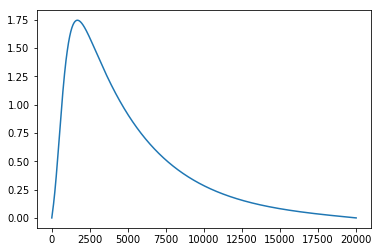

In [23]:
# Declaring constants

# Grid in fm
r_max = 20.0
# Number of steps
N = 20000
# Step lengt
h = r_max / N

print(f'Steplengt: {h}')

# Init grid and potential V(r) for every r
# OBS: Never use 0
r = np.linspace(10.**-16, r_max, num=N)
Vr = populate_Vr(np.zeros(N), r)
u = np.zeros(N)
df = pd.DataFrame()

# Set important parameters
# Guessing whatever was meintioned in the exercise
Emin = min(Vr)
Emax = 0.0
E_values = [Emin, Emax]
max_iter = 1000
continuity_tolerance = 0.0000000001
rmp_index = 1000

E_values = [Emin, Emax]
vectors = [Vr, u]
iter_variables = [max_iter, continuity_tolerance]

results = calc_u(E_values, vectors, iter_variables, rmp_index, df)

u = results[0]


print(results[1])

plt.plot(u)

In [20]:

test_df = results[2]


In [11]:
fm_range_df = pd.DataFrame()


for N in range(10000, 25000, 500):
    
    # Number of steps
    N = N
    # Grid in fm
    r_max = N / 1000
    # Step lengt
    h = r_max / N
    
    print(f'r_max in fm: {r_max}')
    
    # Init grid and potential V(r) for every r
    # OBS: Never use 0
    r = np.linspace(10.**-16, r_max, num=N)
    Vr = populate_Vr(np.zeros(N), r)
    u = np.zeros(N)
    df = pd.DataFrame()
    
    # Set important parameters
    # Guessing whatever was meintioned in the exercise
    Emin = min(Vr)
    Emax = 0.0
    E_values = [Emin, Emax]
    max_iter = 100
    continuity_tolerance = 0.0001
    rmp_index = 2000
    
    E_values = [Emin, Emax]
    vectors = [Vr, u]
    iter_variables = [max_iter, continuity_tolerance]
    
    rmp_start = 1950
    results_array = []
    

    for i in range(10):
        
        if i == 0:
            rmp_index = rmp_start
        
        results = calc_u(E_values, vectors, iter_variables, rmp_index, df)
        
        results_array.append(results)
        
        rmp_index = rmp_index + 10
        
        print(f'Calculating rmp_index: {rmp_index}')
    
    E_calc_values = []

    for i in range(len(results_array)):
    
        E_calc_values.append(results_array[i][1])
    
    new_col_string = str(r_max) + 'fm'
    print(f'Saving with col name: {new_col_string}')
    fm_range_df[new_col_string] = E_calc_values
    
fm_range_df.to_csv('10-25fm.csv') 

r_max in fm: 10.0
Within tolerance!
Calculating rmp_index: 1960
Within tolerance!
Calculating rmp_index: 1970
Within tolerance!
Calculating rmp_index: 1980
Within tolerance!
Calculating rmp_index: 1990
Within tolerance!
Calculating rmp_index: 2000
Within tolerance!
Calculating rmp_index: 2010
Within tolerance!
Calculating rmp_index: 2020
Within tolerance!
Calculating rmp_index: 2030
Within tolerance!
Calculating rmp_index: 2040
Within tolerance!
Calculating rmp_index: 2050
Saving with col name: 10.0fm
r_max in fm: 10.5
Within tolerance!
Calculating rmp_index: 1960
Within tolerance!
Calculating rmp_index: 1970
Within tolerance!
Calculating rmp_index: 1980
Within tolerance!
Calculating rmp_index: 1990
Within tolerance!
Calculating rmp_index: 2000
Within tolerance!
Calculating rmp_index: 2010
Within tolerance!
Calculating rmp_index: 2020
Within tolerance!
Calculating rmp_index: 2030
Within tolerance!
Calculating rmp_index: 2040
Within tolerance!
Calculating rmp_index: 2050
Saving with col

In [13]:

fm_range_df


,10.0fm,10.5fm,11.0fm,11.5fm,12.0fm,12.5fm,13.0fm,13.5fm,14.0fm,14.5fm,...,20.0fm,20.5fm,21.0fm,21.5fm,22.0fm,22.5fm,23.0fm,23.5fm,24.0fm,24.5fm
0,-2.798508,-2.708849,-2.632985,-2.569322,-2.515208,-2.470114,-2.432447,-2.742738e-29,-0.091250,-0.197354,...,-0.679069,-0.693924,-0.706656,-0.717267,-0.725755,-0.734243,-0.740610,-0.744854,-0.751220,-0.755464
1,-2.808588,-2.717338,-2.640942,-2.575688,-2.521044,-2.475419,-2.436691,-2.742738e-29,-0.123081,-0.229186,...,-0.708778,-0.723633,-0.734243,-0.744854,-0.753342,-0.761831,-0.768197,-0.772441,-0.778807,-0.783052
2,-2.818137,-2.726357,-2.648370,-2.582585,-2.526880,-2.480194,-2.441200,-2.546509e-02,-0.154913,-0.261017,...,-0.738488,-0.751220,-0.763953,-0.772441,-0.780929,-0.789418,-0.795784,-0.800028,-0.806395,-0.810639
3,-2.828217,-2.734845,-2.655797,-2.589482,-2.532716,-2.485499,-2.445445,-5.729646e-02,-0.184622,-0.290726,...,-0.766075,-0.778807,-0.791540,-0.802150,-0.810639,-0.817005,-0.823371,-0.827615,-0.831860,-0.836104
4,-2.838297,-2.743864,-2.663755,-2.595848,-2.538551,-2.490274,-2.449954,-8.700573e-02,-0.214331,-0.320436,...,-0.793662,-0.806395,-0.819127,-0.827615,-0.836104,-0.844592,-0.850958,-0.855203,-0.859447,-0.863691
5,-2.847846,-2.752352,-2.671182,-2.602745,-2.544652,-2.495579,-2.454198,-1.167150e-01,-0.244040,-0.350145,...,-0.821249,-0.833982,-0.846714,-0.855203,-0.863691,-0.870057,-0.876424,-0.882790,-0.887034,-0.889156
6,-2.857396,-2.760841,-2.679140,-2.609642,-2.550753,-2.500884,-2.458708,-1.464243e-01,-0.273750,-0.379854,...,-0.848836,-0.861569,-0.872179,-0.882790,-0.891278,-0.897644,-0.904011,-0.908255,-0.912499,-0.916743
7,-2.866945,-2.769329,-2.686567,-2.616008,-2.556589,-2.505659,-2.463217,-1.740115e-01,-0.301337,-0.407441,...,-0.874301,-0.889156,-0.899766,-0.908255,-0.916743,-0.923110,-0.929476,-0.933720,-0.937964,-0.942208
8,-2.876495,-2.777817,-2.693995,-2.622905,-2.562425,-2.510964,-2.467461,-2.015986e-01,-0.328924,-0.435029,...,-0.901889,-0.914621,-0.925232,-0.933720,-0.942208,-0.948575,-0.954941,-0.959185,-0.963429,-0.967673
9,-2.886044,-2.786306,-2.701952,-2.629801,-2.568261,-2.516269,-2.472236,-2.291858e-01,-0.356511,-0.462616,...,-0.927354,-0.940086,-0.950697,-0.959185,-0.967673,-0.974040,-0.980406,-0.984650,-0.988894,-0.991016


In [ ]:
# Debugging
print('Testing')
debugger([E], ['E'])

u = u / (np.sum(u)*10/u.size)

print(np.sum(u))

plt.plot(r[0:20000],u[0:20000])
plt.show()

# After the code works:
# 1. Normalize the function so that the integral = 1
# 2. Calculate the observed radius in fm
# 3. Plot the wave function u(r)
# 4. Analyse the results
